In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import os 
import glob

import numpy as np
import math
from collections import defaultdict
import sys
from time import time
import matplotlib.pyplot as plt
import matplotlib.image as mpli
% matplotlib inline
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as VGG_preprocess

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as IR_preprocess

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as IV_preprocess

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as X_preprocess

from keras.preprocessing import image
from keras.models import Sequential, load_model, Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, History, ReduceLROnPlateau
from keras.optimizers import Adam  
               
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   



Using TensorFlow backend.


In [2]:
def paths_to_tensor1(img_paths,size=(299,299)):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        img = image.load_img(img_path, target_size=size)
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
        x = image.img_to_array(img)
        list_of_tensors.append(x)
        #list_of_tensors.append(np.expand_dims(x, axis=0))
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    #return np.expand_dims(x, axis=0)
    return np.stack(list_of_tensors, 0)

def load_train_data(path, size=(299,299)):
    X = []
    y = []
    for i in range(10):
        files = glob.glob(os.path.join(path, 'c'+str(i),'*.jpg'))
        x = paths_to_tensor1(files, size=size)
        X.extend(x)
        y.extend([i]*len(files)) 
    #return X, y
    #print(len(np.stack(X, 0)),len(y))
    return np.stack(X, 0),np.asarray(y)

def image_preprocess(model_name, X):
    if model_name == 'vgg16':
        X = VGG_preprocess(X)
    if model_name == 'inception_v3':
        X = IV_preprocess(X)
    if model_name == 'inception_resnet_v2':
        X = IR_preprocess(X)
    if model_name == 'xception':
        X = X_preprocess(X)
        
    return X

def save_model(model, cross=''):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    json_name = 'architecture_'  + cross + '.json'
    weight_name = 'model_weights_'  + cross + '.h5'
    open(os.path.join('cache', json_name), 'w').write(json_string)
    model.save_weights(os.path.join('cache', weight_name), overwrite=True)

def create_submission(predictions, img_names, model_name):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], index = img_names)
    result1.loc['img', :] = pd.Series(img_names, index=result1.index)
    #now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    #suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm',model_name + 'submission.csv') 
    result1.to_csv(sub_file, index=False)


In [2]:
def create_model(b_model, n_classes = 10, set_weights = 'imagenet', locked_layers=0, input_shape=(299,299,3), include_top=False):
    base = b_model(weights= set_weights, include_top=include_top, input_shape=input_shape)
    fc = base.output
    fc = GlobalAveragePooling2D()(fc)
    fc = Dropout(0.5)(fc)
    mypredictions = Dense(n_classes, activation='softmax', name='mypredictions')(fc)
    model = Model(inputs=base.input, outputs=mypredictions,name = base.name)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()
    
    if locked_layers>len(model.layers):
        locked_layers = len(model.layers)
    for layer in model.layers[:locked_layers]:
        layer.trainable = False
    for layer in model.layers[locked_layers:]:
        layer.trainable = True 

    return model
#vgg16 xception inception_resnet_v2 inception_v3

In [6]:
base_model = VGG16
model = create_model(b_model=base_model, n_classes = 10, set_weights = None, locked_layers=locked_layers, input_shape=(224,224,3), include_top=False)   
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
for layer in model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [5]:
batch_size = 128
n_epoch = 100
learning_rate = 0.01
locked_layers = 0

In [5]:
trian_set_path=os.path.join('datasets','train')

X, y = load_train_data(trian_set_path,size = (224,224))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=35)

# One hot encoding of the classes
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)#
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

100%|██████████| 2129/2129 [00:10<00:00, 206.67it/s]


X_train shape: (17939, 224, 224, 3)
y_train shape: (17939, 10)
X_val shape: (4485, 224, 224, 3)
y_val shape: (4485, 10)


Train on 17939 samples, validate on 4485 samples
Epoch 1/100
17939/17939 [==============================] - 96s 5ms/step - loss: 14.5021 - acc: 0.0955 - val_loss: 14.4829 - val_acc: 0.1014

Epoch 00001: val_loss improved from inf to 14.48293, saving model to saved_models/vgg16weights.01-14.48.hdf5
Epoch 2/100
17939/17939 [==============================] - 93s 5ms/step - loss: 14.5942 - acc: 0.0945 - val_loss: 14.4829 - val_acc: 0.1014

Epoch 00002: val_loss did not improve from 14.48293
Epoch 3/100
17939/17939 [==============================] - 93s 5ms/step - loss: 14.5520 - acc: 0.0972 - val_loss: 14.4829 - val_acc: 0.1014

Epoch 00003: val_loss did not improve from 14.48293
Epoch 4/100
17939/17939 [==============================] - 93s 5ms/step - loss: 14.5538 - acc: 0.0971 - val_loss: 14.4829 - val_acc: 0.1014

Epoch 00004: val_loss did not improve from 14.48293
Training time: 383


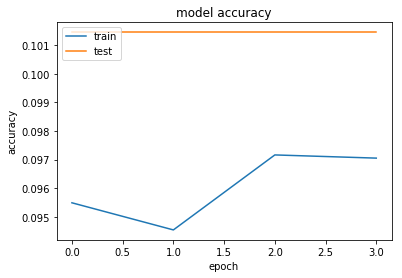

In [22]:
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto') 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

if not os.path.isdir('saved_models'):
    os.mkdir('saved_models')
    
#models = [VGG16,InceptionResNetV2,Xception,InceptionV3]
#models = [VGG16,InceptionResNetV2,Xception]
base_model = VGG16
#for i in models:
model = create_model(b_model=base_model, n_classes = 10, set_weights = None, locked_layers=locked_layers, input_shape=(224,224,3), include_top=False)   
    #weights_path = os.path.join('saved_models',model.name+'.weights.best.hdf5')
weights_path = os.path.join('saved_models',model.name+'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)

s1 = time()
history = model.fit(image_preprocess(model.name, X_train), y_train, 
                    validation_data=(image_preprocess(model.name, X_val), y_val), 
                    epochs=n_epoch, batch_size=batch_size, callbacks=[checkpointer, early_stopping, reduce_lr2], verbose=1)
print("Training time: %d"%(time()-s1))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig(os.path.join('saved_models',model.name+'_acc.jpg'))
    
save_model(model, cross=model.name)
